#Library

In [83]:
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets, utils
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import multiprocessing as mp

num_workers = mp.cpu_count() - 1

#vector_quantizer

In [84]:
# finding the z_e_q given x (by comparing with z_e_x)
class VectorQuantization(Function):
    def forward(ctx, inputs, codeBook):
        with torch.no_grad():
            # assigning the dimension of our embedding
            embedding_size = codeBook.size(1)

            inputs_size = inputs.size()
            # Flatten input
            inputs_flatten = inputs.view(-1, embedding_size)

            codeBook_sqr = torch.sum(codeBook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances of the inputs to the codeBook
            distances = torch.addmm(codeBook_sqr + inputs_sqr,
                                    inputs_flatten, codeBook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
                           '`VectorQuantization`. The function `VectorQuantization` '
                           'is not differentiable. Use `VectorQuantizationStraightThrough` '
                           'if you want a straight-through estimator of the gradient.')


# Required to pass gradients received by z_e_q to z_e_x as torch.min function makes the back-propagation gradient
# impossible
class VectorQuantizationStraightThrough(Function):
    def forward(ctx, inputs, codeBook):

        # evaluating the indices with the least distance between inputs and codeBook
        indices = vq(inputs, codeBook)
        indices_flatten = indices.view(-1)
        # saving indices for backward pass
        ctx.save_for_backward(indices_flatten, codeBook)
        ctx.mark_non_differentiable(indices_flatten)
        codes_flatten = torch.index_select(codeBook, dim=0,
                                           index=indices_flatten)
        # get embedding corresponding to the inputs
        codes = codes_flatten.view_as(inputs)

        return codes, indices_flatten

    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codeBook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient with respect to the codeBook
            indices, codeBook = ctx.saved_tensors
            embedding_size = codeBook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                   .view(-1, embedding_size))

            # for passing gradient backwards
            grad_codeBook = torch.zeros_like(codeBook)
            grad_codeBook.index_add_(0, indices, grad_output_flatten)

        return grad_inputs, grad_codeBook


vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply
__all__ = [vq, vq_st]

#modules

In [85]:
# function
def to_scalar(arr):
    if type(arr) == list:
        return [x.item() for x in arr]
    else:
        return arr.item()

# Function to initialize the weights of our network
def weights_init(m):
    className = m.__class__.__name__
    if className.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", className)

# Structure of the embedding layer
class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        # creating the embedding
        self.embedding = nn.Embedding(K, D)
        # weights belong to a uniform distribution
        self.embedding.weight.data.uniform_(-1. / K, 1. / K)

    # z_e_x --> latent code for the input image
    def forward(self, z_e_x):
        # converting BCHW --> BHWC
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        # Retrieving the indices corresponding to the input
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    # z_e_x --> latent code for the input image
    def straight_through(self, z_e_x):
        # converting BCHW --> BHWC
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()

        # z_q_x --> latent code from the embedding nearest to the input code
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        # z_q_x_bar --> backprop possible
        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
                                               dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        # used for generating the image (decoding)
        return z_q_x, z_q_x_bar

# Structure of the residual block
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


# Architecture of VQ-VAE
class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codeBook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codeBook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codeBook.embedding(latents).permute(0, 3, 1, 2)  # (B, C, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codeBook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

#VQ_VAE

In [86]:
def train(data_loader, model, optimizer):
    for images, _ in data_loader:

        optimizer.zero_grad()
        x_tilde, z_e_x, z_q_x = model(images)

        # Reconstruction loss
        loss_recons = F.mse_loss(x_tilde, images)
        # Vector quantization objective
        loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
        # Commitment objective
        loss_commit = F.mse_loss(z_e_x, z_q_x.detach())

        loss = loss_recons + loss_vq + 0.1 * loss_commit
        loss.backward()
        optimizer.step()

def test(data_loader, model):
    with torch.no_grad():
        loss_recons, loss_vq = 0., 0.
        for images, _ in data_loader:
            x_tilde, z_e_x, z_q_x = model(images)
            loss_recons += F.mse_loss(x_tilde, images)
            loss_vq += F.mse_loss(z_q_x, z_e_x)

        loss_recons /= len(data_loader)
        loss_vq /= len(data_loader)

    print('loss/test/reconstruction: {:f}'.format(loss_recons.item()))
    print('loss/test/quantization: {:f}'.format(loss_vq.item()))

    return loss_recons.item(), loss_vq.item()

def generate_samples(images, model):
    with torch.no_grad():
        x_tilde, _, _ = model(images)
    return x_tilde


#Datasets

In [87]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
# Define the train & test dataSets
train_set = datasets.MNIST(root='./data', train=True,
                               download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False,
                              download=True, transform=transform)
num_channels = 1
# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=64, shuffle=True,
                                           num_workers=num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set, num_workers=num_workers,
                                          batch_size=16, shuffle=False)

#Create a SummaryWriter for logging

In [88]:
writer = SummaryWriter()

# Fixed images for TensorBoard
fixed_images, _ = next(iter(test_loader))
fixed_grid = make_grid(fixed_images, nrow=8, normalize=True)

# Add the image grid to TensorBoard
writer.add_image('original', fixed_grid, 0)

# Close the SummaryWriter when done
writer.close()

#hyperparameters

In [89]:
hidden_size=40
k=512
lr=2e-4
model = VectorQuantizedVAE(num_channels, hidden_size, k)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
writer.add_graph(model, fixed_images)  # get model structure on tensorboard

#Begin Training

In [90]:
img_list = []
best_loss = -1.
loss_list = []
for epoch in range(3):
    train(train_loader, model, optimizer)
    loss, _ = test(test_loader, model)

    reconstruction = generate_samples(fixed_images, model)
    grid = make_grid(reconstruction.cpu(), nrow=8, normalize=True)

    print("loss = {:f} at epoch {:f}".format(loss, epoch + 1))

    loss_list.append(loss)
    img_list.append(grid)

    if (epoch == 0) or (loss < best_loss):
        best_loss = loss
        best_model = model.state_dict()
        # Save the best model to a file
        torch.save(best_model, 'best_VQ_vae__model.pth')
        print("Best model saved as 'best_VQ_vae__model.pth'")

loss/test/reconstruction: 0.087498
loss/test/quantization: 4.931571
loss = 0.087498 at epoch 1.000000
Best model saved as 'best_VQ_vae__model.pth'
loss/test/reconstruction: 0.079428
loss/test/quantization: 7.475148
loss = 0.079428 at epoch 2.000000
Best model saved as 'best_VQ_vae__model.pth'
loss/test/reconstruction: 0.074180
loss/test/quantization: 6.290815
loss = 0.074180 at epoch 3.000000
Best model saved as 'best_VQ_vae__model.pth'


#Plot Loss

Text(0.5, 0, 'Epoch')

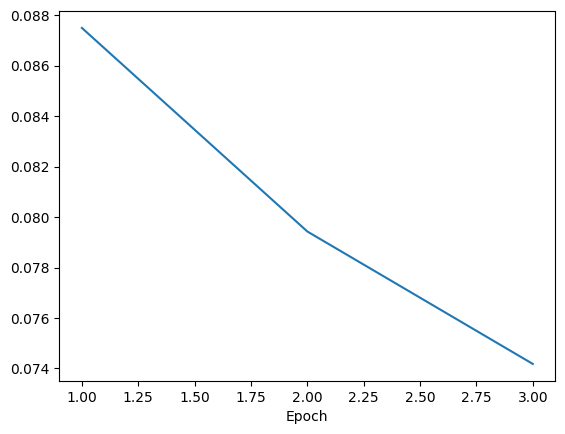

In [91]:
plt.plot(range(1, epoch + 2), loss_list, label=' Loss')
plt.xlabel('Epoch')

#original & reconstruction Plot

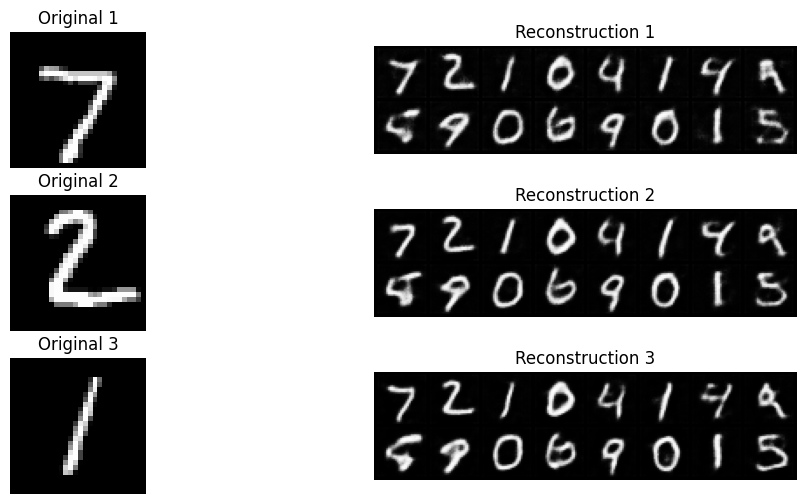

In [92]:
# Convert them to NumPy arrays before plotting
img_list_np = [img.numpy() for img in img_list]

# Plot each original and reconstructed image pair
plt.figure(figsize=(12, 6))
for i, (original, reconstruction) in enumerate(zip(fixed_images, img_list_np)):
    plt.subplot(len(img_list), 2, 2 * i + 1)
    plt.imshow(np.transpose(make_grid(original, nrow=8, normalize=True).numpy(), (1, 2, 0)))
    plt.title(f'Original {i + 1}')
    plt.axis('off')

    plt.subplot(len(img_list), 2, 2 * i + 2)
    plt.imshow(np.transpose(reconstruction, (1, 2, 0)))
    plt.title(f'Reconstruction {i + 1}')
    plt.axis('off')

plt.show()